### **Notepad for Dissertation TL Fine tuning with default learning rate for six pretrained models using NSL-KDD Datasets**
###for images with resolution 224 x 224


# NSL-KDD Dataset preparation using text to image conversion

In [ ]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
train = 'https://raw.githubusercontent.com/sepahpourka/NSL-KDD-Datasets/main/KDDTrain%2B.txt'
test = 'https://raw.githubusercontent.com/sepahpourka/NSL-KDD-Datasets/main/KDDTest%2B.txt'
test21 = 'https://raw.githubusercontent.com/sepahpourka/NSL-KDD-Datasets/main/KDDTest-21.txt'

In [ ]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

In [ ]:
#train_data = pd.read_csv(train,names=feature)
test_data = pd.read_csv(test,names=feature)
#data = pd.concat([train_data, test_data], ignore_index=True)
data = pd.concat([test_data], ignore_index=True)

data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22540,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22541,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
22542,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21


In [ ]:
# Redistribute across common attack class
# Type of attacks: DoS (Denial of Service attacks), R2L (Root to Local attacks), U2R (User to Root attack) and Probe (Probing attacks).
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'abnormal',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'abnormal',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'abnormal',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'abnormal',inplace=True)

change_label(data)

In [ ]:
# distribution of attack classes
data.label.value_counts()

abnormal    12833
normal       9711
Name: label, dtype: int64

In [ ]:
label = pd.DataFrame(data.label)


# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
from sklearn import preprocessing
le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label
print(data.shape)
data

(22544, 44)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty,intrusion
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,abnormal,21,0
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,abnormal,21,0
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21,1
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,abnormal,15,0
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,abnormal,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21,1
22540,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21,1
22541,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,abnormal,15,0
22542,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21,1


In [ ]:
def change_label(df):
  df.intrusion.replace(0,2,inplace=True)
  df.intrusion.replace(1,0,inplace=True)
  df.intrusion.replace(2,1,inplace=True)
change_label(data)

In [ ]:
df = pd.DataFrame(data)

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty,intrusion
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,abnormal,21,1
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,abnormal,21,1
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,0
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,abnormal,15,1
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,abnormal,11,1


In [ ]:
df['information'] = df['duration'].astype(str) + " "+ df['protocol_type'].astype(str) + " "+ df['service'].astype(str) + " "+ df['flag'].astype(str) + " "+ df['src_bytes'].astype(str) + " "+ df['dst_bytes'].astype(str) + " "+ df['land'].astype(str) + " "+ df['wrong_fragment'].astype(str) + " "+ df['urgent'].astype(str) + " "+ df['hot'].astype(str) + " "+ df['num_failed_logins'].astype(str) + " "+ df['logged_in'].astype(str) + " "+ df['num_compromised'].astype(str) + " "+ df['root_shell'].astype(str) + " "+ df['su_attempted'].astype(str) + " "+ df['num_root'].astype(str) + " "+ df['num_file_creations'].astype(str) + " "+ df['num_shells'].astype(str) + " "+ df['num_access_files'].astype(str) + " "+ df['num_outbound_cmds'].astype(str) + " "+ df['is_host_login'].astype(str) + " "+ df['is_guest_login'].astype(str) + " "+ df['count'].astype(str) + " "+ df['srv_count'].astype(str) + " "+ df['serror_rate'].astype(str) + " "+ df['srv_serror_rate'].astype(str) + " "+ df['rerror_rate'].astype(str) + " "+ df['srv_rerror_rate'].astype(str) + " "+ df['same_srv_rate'].astype(str) + " "+ df['diff_srv_rate'].astype(str) + " "+ df['srv_diff_host_rate'].astype(str) + " "+ df['dst_host_count'].astype(str) + " "+ df['dst_host_srv_count'].astype(str) + " "+ df['dst_host_same_srv_rate'].astype(str) + " "+ df['dst_host_diff_srv_rate'].astype(str) + " "+ df['dst_host_same_src_port_rate'].astype(str) + " "+ df['dst_host_srv_diff_host_rate'].astype(str) + " "+ df['dst_host_serror_rate'].astype(str) + " "+ df['dst_host_srv_serror_rate'].astype(str) + " "+ df['dst_host_rerror_rate'].astype(str) + " "+ df['dst_host_srv_rerror_rate'].astype(str)


# remove attribute 'difficulty_level'
df.drop(['duration'],axis=1,inplace=True)
df.drop(['protocol_type'],axis=1,inplace=True)
df.drop(['service'],axis=1,inplace=True)
df.drop(['flag'],axis=1,inplace=True)
df.drop(['src_bytes'],axis=1,inplace=True)
df.drop(['dst_bytes'],axis=1,inplace=True)
df.drop(['land'],axis=1,inplace=True)
df.drop(['wrong_fragment'],axis=1,inplace=True)
df.drop(['urgent'],axis=1,inplace=True)
df.drop(['hot'],axis=1,inplace=True)
df.drop(['num_failed_logins'],axis=1,inplace=True)
df.drop(['logged_in'],axis=1,inplace=True)
df.drop(['num_compromised'],axis=1,inplace=True)
df.drop(['root_shell'],axis=1,inplace=True)
df.drop(['su_attempted'],axis=1,inplace=True)
df.drop(['num_root'],axis=1,inplace=True)
df.drop(['num_file_creations'],axis=1,inplace=True)
df.drop(['num_shells'],axis=1,inplace=True)
df.drop(['num_access_files'],axis=1,inplace=True)
df.drop(['num_outbound_cmds'],axis=1,inplace=True)
df.drop(['is_host_login'],axis=1,inplace=True)
df.drop(['is_guest_login'],axis=1,inplace=True)
df.drop(['count'],axis=1,inplace=True)
df.drop(['srv_count'],axis=1,inplace=True)
df.drop(['serror_rate'],axis=1,inplace=True)
df.drop(['srv_serror_rate'],axis=1,inplace=True)
df.drop(['rerror_rate'],axis=1,inplace=True)
df.drop(['srv_rerror_rate'],axis=1,inplace=True)
df.drop(['same_srv_rate'],axis=1,inplace=True)
df.drop(['diff_srv_rate'],axis=1,inplace=True)
df.drop(['srv_diff_host_rate'],axis=1,inplace=True)
df.drop(['dst_host_count'],axis=1,inplace=True)
df.drop(['dst_host_srv_count'],axis=1,inplace=True)
df.drop(['dst_host_same_srv_rate'],axis=1,inplace=True)
df.drop(['dst_host_diff_srv_rate'],axis=1,inplace=True)
df.drop(['dst_host_same_src_port_rate'],axis=1,inplace=True)
df.drop(['dst_host_srv_diff_host_rate'],axis=1,inplace=True)
df.drop(['dst_host_serror_rate'],axis=1,inplace=True)
df.drop(['dst_host_srv_serror_rate'],axis=1,inplace=True)
df.drop(['dst_host_rerror_rate'],axis=1,inplace=True)
df.drop(['dst_host_srv_rerror_rate'],axis=1,inplace=True)
df.drop(['difficulty'],axis=1,inplace=True)

df.head()

,label,intrusion,information
0,abnormal,1,0 tcp private REJ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,abnormal,1,0 tcp private REJ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,normal,0,2 tcp ftp_data SF 12983 0 0 0 0 0 0 0 0 0 0 0 ...
3,abnormal,1,0 icmp eco_i SF 20 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
4,abnormal,1,1 tcp telnet RSTO 0 15 0 0 0 0 0 0 0 0 0 0 0 0...


In [ ]:
df

,label,intrusion,information
0,abnormal,1,0 tcp private REJ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,abnormal,1,0 tcp private REJ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,normal,0,2 tcp ftp_data SF 12983 0 0 0 0 0 0 0 0 0 0 0 ...
3,abnormal,1,0 icmp eco_i SF 20 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
4,abnormal,1,1 tcp telnet RSTO 0 15 0 0 0 0 0 0 0 0 0 0 0 0...
...,...,...,...
22539,normal,0,0 tcp smtp SF 794 333 0 0 0 0 0 1 0 0 0 0 0 0 ...
22540,normal,0,0 tcp http SF 317 938 0 0 0 0 0 1 0 0 0 0 0 0 ...
22541,abnormal,1,0 tcp http SF 54540 8314 0 0 0 2 0 1 1 0 0 0 0...
22542,normal,0,0 udp domain_u SF 42 42 0 0 0 0 0 0 0 0 0 0 0 ...


In [ ]:
df.shape

(22544, 3)

In [ ]:
!pip3 install text_to_image

  Preparing metadata (setup.py) ... done
  Created wheel for text_to_image: filename=text_to_image-0.0.5-py3-none-any.whl size=7672 sha256=df6deca406cee6800a21c8f5e3e5f7e2a1a582ed9b4a2f6f3f6bb71f6c367702
  Stored in directory: /root/.cache/pip/wheels/29/68/8b/d092e42381babc9c3a3f104e98800984c8fd642c5c0b5fab4f
Successfully built text_to_image


In [ ]:
# importing os module
import os
import shutil

# path
images_path = '/content/images'
if os.path.isdir(images_path):
  shutil.rmtree(images_path)
else:
   print("Given directory doesn't exist")


Given directory doesn't exist


In [ ]:
# path
images_path = '/content/images'
normal_path = '/content/images/normal'
abnormal_path = '/content/images/abnormal'

try:
    os.mkdir(images_path)
    os.mkdir(normal_path)
    os.mkdir(abnormal_path)
except OSError as error:
    print(error)

In [ ]:
import text_to_image

for index in df.index:
  filename = "/content/images/" + df.loc[index,'label'] + "/" + "image_" + str(index) +".png"
  df.loc[index,'information'] = text_to_image.encode(df.loc[index,'information'], filename)


In [ ]:
import pathlib
data_dir = "/content/images"
data_dir = pathlib.Path(data_dir).with_suffix('')

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

22544


In [ ]:
import PIL

normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[0]))

In [ ]:
abnormal = list(data_dir.glob('abnormal/*'))
PIL.Image.open(str(abnormal[1]))

In [ ]:
print(df.loc[0,'information'])

/content/images/abnormal/image_0.png


In [ ]:
from PIL import Image
# iterate over files in
# that directory
for filename in os.listdir('/content/images/normal'):
    image = Image.open("/content/images/normal/" + filename)
    new_image = image.resize((224, 224))
    new_image.save("/content/images/normal/" + filename)
for filename in os.listdir('/content/images/abnormal'):
    image = Image.open("/content/images/abnormal/" + filename)
    new_image = image.resize((224, 224))
    new_image.save("/content/images/abnormal/" + filename)

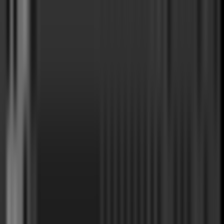

In [ ]:
Probe = list(data_dir.glob('abnormal/*'))
PIL.Image.open(str(Probe[1]))

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
input_file = '/content/images'
output_files = '/content/split_images'

In [ ]:
splitfolders.ratio(input_file,output=output_files, seed=38, ratio=(0.80, 0.20), group_prefix=None)

Copying files: 22544 files [00:02, 8262.71 files/s] 


In [ ]:
input_file = '/content/split_images/train'
output_files = '/content/split_images/split_again/'

In [ ]:
splitfolders.ratio(input_file,output=output_files, seed=38, ratio=(0.75, 0.25), group_prefix=None)

Copying files: 18034 files [00:02, 8856.47 files/s] 


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

print("Generating Training Data")
train_generator = data_generator.flow_from_directory(
    '/content/split_images/split_again/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training",
    shuffle=True,
    seed=123,
    class_mode='binary')
print(train_generator.class_indices)
x_train, y_train = next(train_generator)

print("Generating Validation Data")
validation_generator = data_generator.flow_from_directory(
    '/content/split_images/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation",
    shuffle=True,
    seed=123,
    class_mode='binary')
print(validation_generator.class_indices)
x_val, y_val = next(validation_generator)

print("Generating Testing Data")
test_generator = data_generator.flow_from_directory(
    '/content/split_images/split_again/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    seed=123,
    class_mode='binary')
print(test_generator.class_indices)
x_test, y_test = next(test_generator)

Generating Training Data
Found 10821 images belonging to 2 classes.
{'abnormal': 0, 'normal': 1}
Generating Validation Data
Found 901 images belonging to 2 classes.
{'abnormal': 0, 'normal': 1}
Generating Testing Data
Found 4509 images belonging to 2 classes.
{'abnormal': 0, 'normal': 1}


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/split_images/split_again/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(train_ds.class_names)

Found 13525 files belonging to 2 classes.
Using 10820 files for training.
['abnormal', 'normal']


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/split_images/val',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(val_ds.class_names)

Found 4510 files belonging to 2 classes.
Using 902 files for validation.
['abnormal', 'normal']


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/split_images/split_again/val',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(test_ds.class_names)

Found 4509 files belonging to 2 classes.
['abnormal', 'normal']


In [ ]:
class_names = train_ds.class_names
print(class_names)

['abnormal', 'normal']


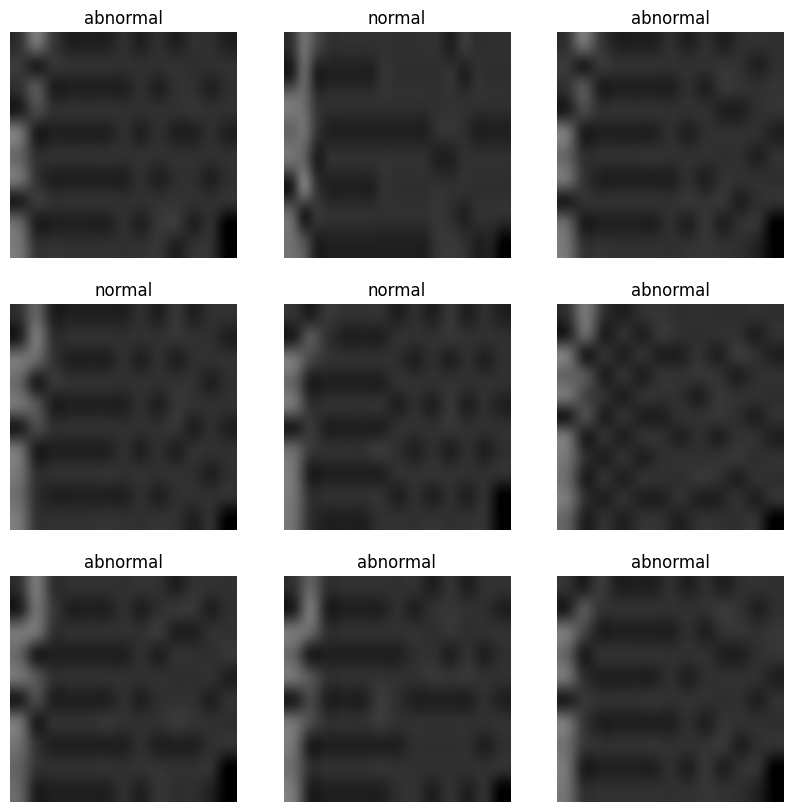

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.5019608


# Transfer Learning using Imagenet classification with ResNet V2 50

In [ ]:
epochs=10
batchsize=10

In [ ]:
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow_hub as hub
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

hub_layer = hub.KerasLayer('https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5', trainable=True, arguments=dict(batch_norm_momentum=0.997))

tmodel = Sequential()
tmodel.add(hub_layer)

# add two hidden layers for classification
tmodel.add(Dense(512, activation='relu'))
tmodel.add(Dense(256, activation='relu'))

# add the prediction layer
tmodel.add(Dense(1,activation="sigmoid"))

tmodel.build([None, 224, 224, 3])  # Batch input shape.

tmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 512)               513024    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26260458 (100.18 MB)
Trainable params: 26215018 (100.00 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [ ]:
tmodel.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = tmodel.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 143s 305ms/step - loss: 0.6618 - binary_accuracy: 0.8910 - val_loss: 2674.5806 - val_binary_accuracy: 0.4457
Epoch 2/10
339/339 [==============================] - 102s 302ms/step - loss: 0.4909 - binary_accuracy: 0.9357 - val_loss: 4.4920 - val_binary_accuracy: 0.6330
Epoch 3/10
339/339 [==============================] - 103s 303ms/step - loss: 0.3976 - binary_accuracy: 0.9480 - val_loss: 1.7007 - val_binary_accuracy: 0.7550
Epoch 4/10
339/339 [==============================] - 103s 303ms/step - loss: 0.3957 - binary_accuracy: 0.9401 - val_loss: 0.6691 - val_binary_accuracy: 0.8337
Epoch 5/10
339/339 [==============================] - 103s 303ms/step - loss: 0.3275 - binary_accuracy: 0.9497 - val_loss: 1.5304 - val_binary_accuracy: 0.6818
Epoch 6/10
339/339 [==============================] - 103s 303ms/step - loss: 0.3391 - binary_accuracy: 0.9453 - val_loss: 1.7339 - val_binary_accuracy: 0.6663
Epoch 7/10
339/339 [=================

In [ ]:
# lets save the model now
tmodel.save("MODEL1-TL-FTDLR-NSL-KDD.keras")

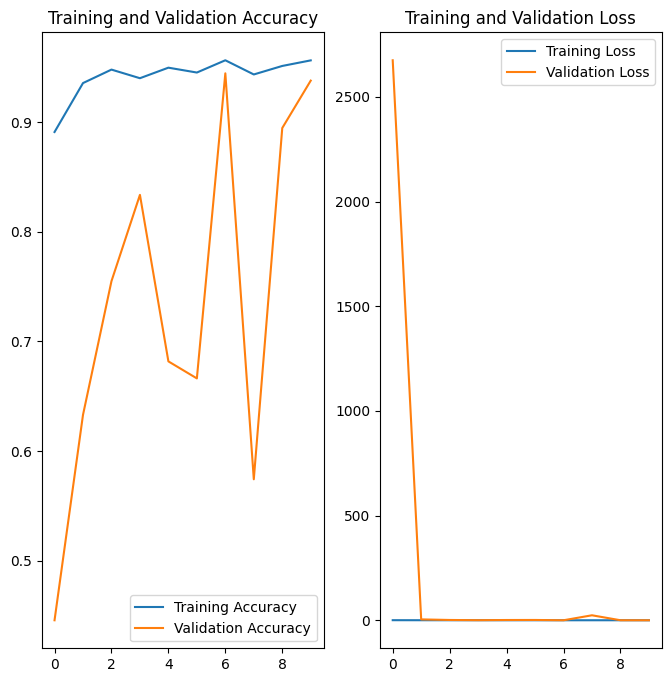

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = tmodel.predict(test_generator)

141/141 [==============================] - 14s 93ms/step


[[2351  216]
 [  91 1851]]


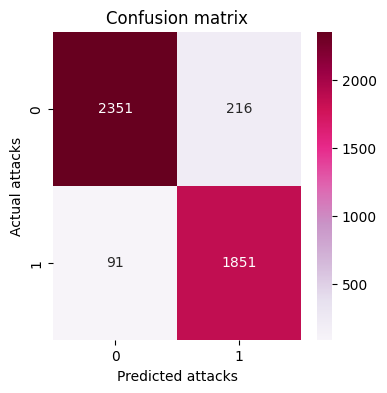

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2351  216]
 [  91 1851]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.96      0.92      0.94      2567
      normal       0.90      0.95      0.92      1942

    accuracy                           0.93      4509
   macro avg       0.93      0.93      0.93      4509
weighted avg       0.93      0.93      0.93      4509



# Transfer Learning using Imagenet classification with ResNet 50

In [ ]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow_hub as hub
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

hub_layer1 = hub.KerasLayer('https://tfhub.dev/tensorflow/resnet_50/classification/1', trainable=True)

vmodel = Sequential()
vmodel.add(hub_layer1)

# add two hidden layers for classification
vmodel.add(Dense(512, activation='relu'))
vmodel.add(Dense(256, activation='relu'))

# add the prediction layer
vmodel.add(Dense(1, activation=('sigmoid')))

vmodel.build([None, 224, 224, 3])  # Batch input shape.

vmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              25612201  
                                                                 
 dense_3 (Dense)             (None, 512)               513024    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26256810 (100.16 MB)
Trainable params: 26203690 (99.96 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
vmodel.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = vmodel.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 145s 348ms/step - loss: 0.6578 - binary_accuracy: 0.8270 - val_loss: 1.5306 - val_binary_accuracy: 0.5244
Epoch 2/10
339/339 [==============================] - 115s 340ms/step - loss: 0.4937 - binary_accuracy: 0.8732 - val_loss: 1.4995 - val_binary_accuracy: 0.4823
Epoch 3/10
339/339 [==============================] - 115s 340ms/step - loss: 0.5003 - binary_accuracy: 0.8755 - val_loss: 0.8030 - val_binary_accuracy: 0.6630
Epoch 4/10
339/339 [==============================] - 115s 339ms/step - loss: 0.4035 - binary_accuracy: 0.8905 - val_loss: 1.2357 - val_binary_accuracy: 0.5554
Epoch 5/10
339/339 [==============================] - 115s 339ms/step - loss: 0.3946 - binary_accuracy: 0.8856 - val_loss: 0.7352 - val_binary_accuracy: 0.5632
Epoch 6/10
339/339 [==============================] - 115s 338ms/step - loss: 0.3543 - binary_accuracy: 0.8960 - val_loss: 0.5093 - val_binary_accuracy: 0.8082
Epoch 7/10
339/339 [====================

In [ ]:
# lets save the model now
vmodel.save("MODEL2-TL-FTDLR-NSL-KDD.keras")

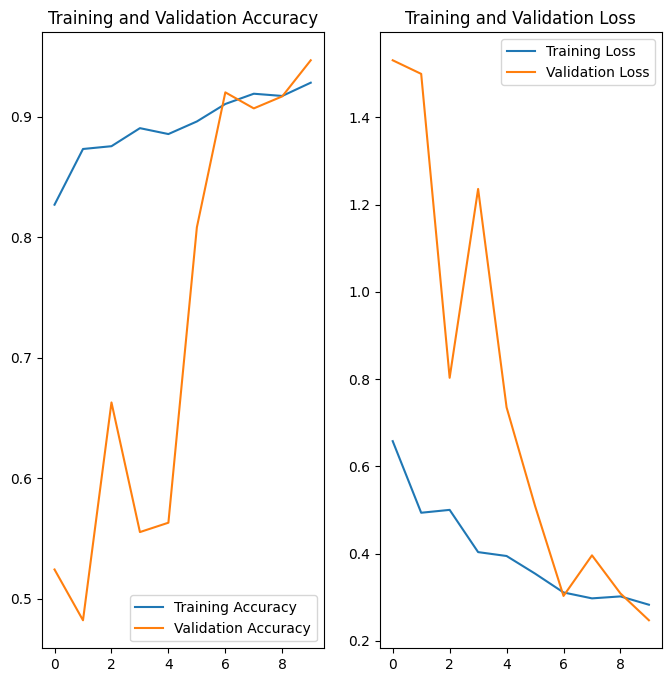

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = vmodel.predict(test_generator)

141/141 [==============================] - 15s 103ms/step


[[2501   66]
 [ 237 1705]]


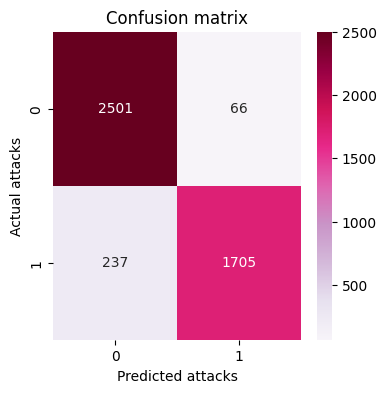

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2501   66]
 [ 237 1705]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.91      0.97      0.94      2567
      normal       0.96      0.88      0.92      1942

    accuracy                           0.93      4509
   macro avg       0.94      0.93      0.93      4509
weighted avg       0.93      0.93      0.93      4509



# Transfer Learning using Imagenet classification with MobileNet V1

In [ ]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow_hub as hub

hub_layer1 = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/5", trainable=True, arguments=dict(batch_norm_momentum=0.997))

wmodel = Sequential()
wmodel.add(hub_layer1)
# add two hidden layers for classification
wmodel.add(Dense(512, activation='relu'))
wmodel.add(Dense(256, activation='relu'))

# add the prediction layer
wmodel.add(Dense(1, activation=('sigmoid')))

wmodel.build([None, 224, 224, 3])  # Batch input shape.

wmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              4254889   
                                                                 
 dense_6 (Dense)             (None, 512)               513024    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4899498 (18.69 MB)
Trainable params: 4877610 (18.61 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


In [ ]:
wmodel.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = wmodel.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 57s 127ms/step - loss: 0.4881 - binary_accuracy: 0.9126 - val_loss: 4.0716 - val_binary_accuracy: 0.5820
Epoch 2/10
339/339 [==============================] - 41s 121ms/step - loss: 0.3508 - binary_accuracy: 0.9554 - val_loss: 2.2633 - val_binary_accuracy: 0.5576
Epoch 3/10
339/339 [==============================] - 41s 122ms/step - loss: 0.3110 - binary_accuracy: 0.9637 - val_loss: 5.1770 - val_binary_accuracy: 0.5798
Epoch 4/10
339/339 [==============================] - 41s 121ms/step - loss: 0.2896 - binary_accuracy: 0.9677 - val_loss: 0.6973 - val_binary_accuracy: 0.8758
Epoch 5/10
339/339 [==============================] - 41s 122ms/step - loss: 0.2656 - binary_accuracy: 0.9721 - val_loss: 1.8805 - val_binary_accuracy: 0.6608
Epoch 6/10
339/339 [==============================] - 41s 122ms/step - loss: 0.2470 - binary_accuracy: 0.9724 - val_loss: 0.3242 - val_binary_accuracy: 0.9424
Epoch 7/10
339/339 [==========================

In [ ]:
# lets save the model now
wmodel.save("MODEL3-TL-FTDLR-NSL-KDD.keras")

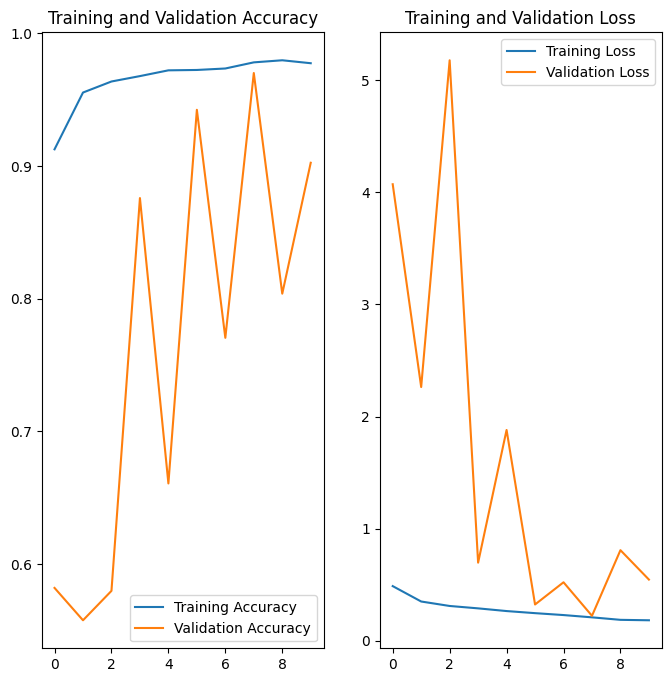

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = wmodel.predict(test_generator)

141/141 [==============================] - 7s 46ms/step


[[2256  311]
 [ 117 1825]]


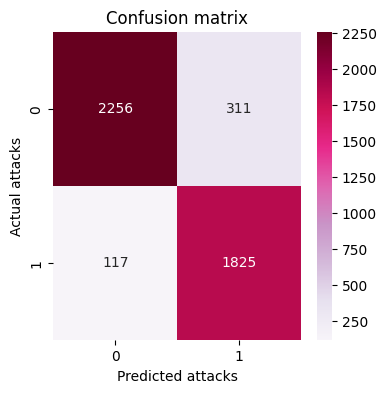

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2256  311]
 [ 117 1825]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.95      0.88      0.91      2567
      normal       0.85      0.94      0.90      1942

    accuracy                           0.91      4509
   macro avg       0.90      0.91      0.90      4509
weighted avg       0.91      0.91      0.91      4509



# Transfer Learning using Imagenet classification with ResNet V2 101.

In [ ]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow_hub as hub

hub_layer1 = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/5",trainable=True)

zmodel = Sequential()
zmodel.add(hub_layer1)

# add two hidden layers for classification
zmodel.add(Dense(512, activation='relu'))
zmodel.add(Dense(256, activation='relu'))

# add the prediction layer
zmodel.add(Dense(1, activation=('sigmoid')))

zmodel.build([None, 224, 224, 3])  # Batch input shape.

zmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              4254889   
                                                                 
 dense_9 (Dense)             (None, 512)               513024    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 4899498 (18.69 MB)
Trainable params: 4877610 (18.61 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


In [ ]:
import keras

zmodel.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = zmodel.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 53s 124ms/step - loss: 0.4890 - binary_accuracy: 0.9128 - val_loss: 0.4606 - val_binary_accuracy: 0.8792
Epoch 2/10
339/339 [==============================] - 41s 121ms/step - loss: 0.3597 - binary_accuracy: 0.9499 - val_loss: 0.3998 - val_binary_accuracy: 0.9335
Epoch 3/10
339/339 [==============================] - 41s 122ms/step - loss: 0.3140 - binary_accuracy: 0.9648 - val_loss: 0.3079 - val_binary_accuracy: 0.9568
Epoch 4/10
339/339 [==============================] - 41s 121ms/step - loss: 0.2792 - binary_accuracy: 0.9717 - val_loss: 0.2674 - val_binary_accuracy: 0.9656
Epoch 5/10
339/339 [==============================] - 41s 121ms/step - loss: 0.2633 - binary_accuracy: 0.9729 - val_loss: 0.2917 - val_binary_accuracy: 0.9579
Epoch 6/10
339/339 [==============================] - 41s 122ms/step - loss: 0.2555 - binary_accuracy: 0.9714 - val_loss: 0.9714 - val_binary_accuracy: 0.8426
Epoch 7/10
339/339 [==========================

In [ ]:
# lets save the model now
zmodel.save("MODEL4-TL-FTDLR-NSL-KDD.keras")

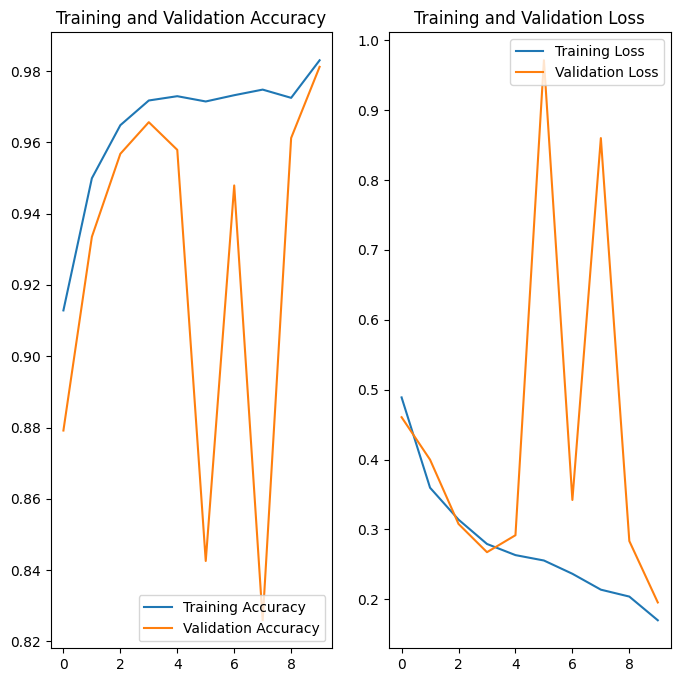

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = zmodel.predict(test_generator)

141/141 [==============================] - 7s 44ms/step


[[2535   32]
 [  79 1863]]


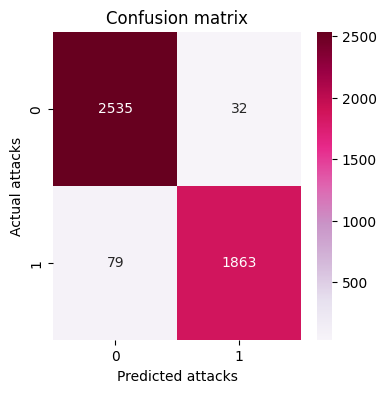

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2535   32]
 [  79 1863]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.97      0.99      0.98      2567
      normal       0.98      0.96      0.97      1942

    accuracy                           0.98      4509
   macro avg       0.98      0.97      0.97      4509
weighted avg       0.98      0.98      0.98      4509



# Transfer Learning using Pretrained-VGG16

In [ ]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
newt_model = Sequential()
newt_model.add(Flatten(input_shape=base_model.output_shape[1:]))

# add two hidden layers for classification
newt_model.add(Dense(512, activation='relu'))
newt_model.add(Dense(256, activation='relu'))

# add the prediction layer
newt_model.add(Dense(1, activation=('sigmoid')))

newt_model = Model(inputs=base_model.input, outputs=newt_model(base_model.output))
newt_model.build([None, 224, 224, 3])  # Batch input shape.
newt_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
import keras

newt_model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#allback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = newt_model.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 155s 411ms/step - loss: 0.8658 - binary_accuracy: 0.5639 - val_loss: 0.6873 - val_binary_accuracy: 0.5543
Epoch 2/10
339/339 [==============================] - 134s 395ms/step - loss: 0.6835 - binary_accuracy: 0.5697 - val_loss: 0.6872 - val_binary_accuracy: 0.5543
Epoch 3/10
339/339 [==============================] - 134s 395ms/step - loss: 0.6837 - binary_accuracy: 0.5697 - val_loss: 0.6884 - val_binary_accuracy: 0.5543
Epoch 4/10
339/339 [==============================] - 134s 395ms/step - loss: 0.6836 - binary_accuracy: 0.5697 - val_loss: 0.6874 - val_binary_accuracy: 0.5543
Epoch 5/10
339/339 [==============================] - 134s 396ms/step - loss: 0.6838 - binary_accuracy: 0.5697 - val_loss: 0.6875 - val_binary_accuracy: 0.5543
Epoch 6/10
339/339 [==============================] - 134s 395ms/step - loss: 0.6838 - binary_accuracy: 0.5697 - val_loss: 0.6875 - val_binary_accuracy: 0.5543
Epoch 7/10
339/339 [====================

In [ ]:
# lets save the model now
newt_model.save("MODEL5-TL-FTDLR-NSL-KDD.keras")

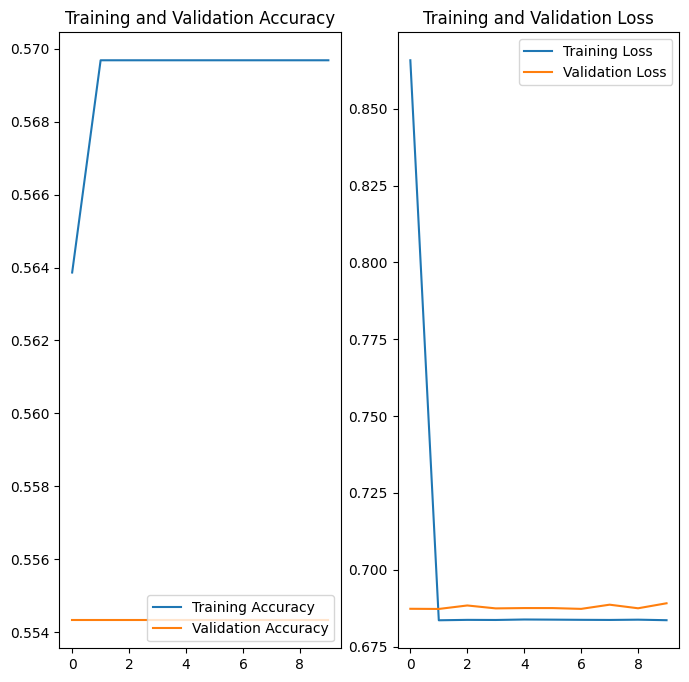

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = newt_model.predict(test_generator)

141/141 [==============================] - 21s 148ms/step


[[2567    0]
 [1942    0]]


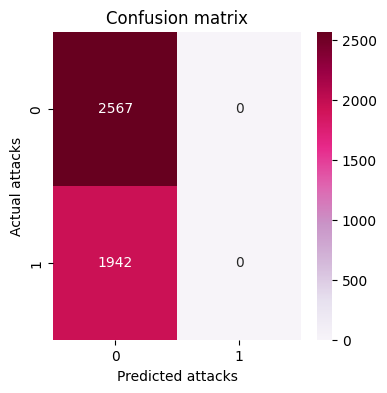

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2567    0]
 [1942    0]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.57      1.00      0.73      2567
      normal       0.00      0.00      0.00      1942

    accuracy                           0.57      4509
   macro avg       0.28      0.50      0.36      4509
weighted avg       0.32      0.57      0.41      4509



# Transfer Learning using Pretrained-VGG19

In [ ]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model1 = applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
newty_model = Sequential()
newty_model.add(Flatten(input_shape=base_model1.output_shape[1:]))

# add two hidden layers for classification
newty_model.add(Dense(512, activation='relu'))
newty_model.add(Dense(256, activation='relu'))

# add the prediction layer
newty_model.add(Dense(1, activation=('sigmoid')))

newty_model = Model(inputs=base_model1.input, outputs=newty_model(base_model1.output))
newty_model.build([None, 224, 224, 3])  # Batch input shape.
newty_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
import keras

newty_model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = newty_model.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 165s 474ms/step - loss: 1.8053 - binary_accuracy: 0.5590 - val_loss: 0.6876 - val_binary_accuracy: 0.5543
Epoch 2/10
339/339 [==============================] - 157s 463ms/step - loss: 0.6839 - binary_accuracy: 0.5697 - val_loss: 0.6884 - val_binary_accuracy: 0.5543
Epoch 3/10
339/339 [==============================] - 156s 459ms/step - loss: 0.6836 - binary_accuracy: 0.5697 - val_loss: 0.6884 - val_binary_accuracy: 0.5543
Epoch 4/10
339/339 [==============================] - 156s 460ms/step - loss: 0.6838 - binary_accuracy: 0.5697 - val_loss: 0.6895 - val_binary_accuracy: 0.5543
Epoch 5/10
339/339 [==============================] - 156s 459ms/step - loss: 0.6835 - binary_accuracy: 0.5697 - val_loss: 0.6892 - val_binary_accuracy: 0.5543
Epoch 6/10
339/339 [==============================] - 156s 460ms/step - loss: 0.6837 - binary_accuracy: 0.5697 - val_loss: 0.6873 - val_binary_accuracy: 0.5543
Epoch 7/10
339/339 [====================

In [ ]:
# lets save the model now
newty_model.save("MODEL6-TL-FTDLR-NSL-KDD.keras")

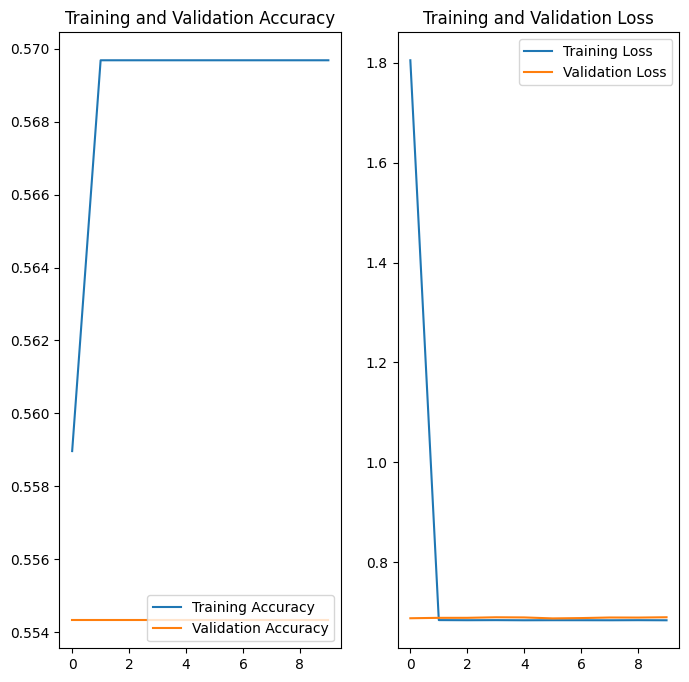

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = newty_model.predict(test_generator)

141/141 [==============================] - 20s 140ms/step


[[2567    0]
 [1942    0]]


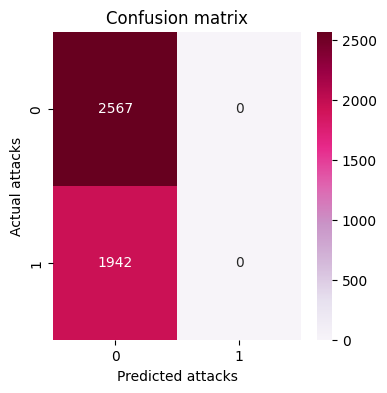

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2567    0]
 [1942    0]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.57      1.00      0.73      2567
      normal       0.00      0.00      0.00      1942

    accuracy                           0.57      4509
   macro avg       0.28      0.50      0.36      4509
weighted avg       0.32      0.57      0.41      4509



# Deep Learning for comparison using Basic Keras DL Model with 3 Conv2D blocks & 3 Max Pooling Layers

In [ ]:
import os
import tensorflow as tf
from keras.models import Sequential

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation=('sigmoid'))
])

In [ ]:
import keras
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
history = model.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/10
339/339 [==============================] - 12s 29ms/step - loss: 0.4363 - binary_accuracy: 0.7969 - val_loss: 0.2439 - val_binary_accuracy: 0.9113
Epoch 2/10
339/339 [==============================] - 9s 28ms/step - loss: 0.2045 - binary_accuracy: 0.9286 - val_loss: 0.1564 - val_binary_accuracy: 0.9424
Epoch 3/10
339/339 [==============================] - 9s 28ms/step - loss: 0.1593 - binary_accuracy: 0.9441 - val_loss: 0.1287 - val_binary_accuracy: 0.9568
Epoch 4/10
339/339 [==============================] - 9s 28ms/step - loss: 0.1352 - binary_accuracy: 0.9528 - val_loss: 0.1430 - val_binary_accuracy: 0.9579
Epoch 5/10
339/339 [==============================] - 9s 28ms/step - loss: 0.1317 - binary_accuracy: 0.9529 - val_loss: 0.1222 - val_binary_accuracy: 0.9623
Epoch 6/10
339/339 [==============================] - 9s 28ms/step - loss: 0.1062 - binary_accuracy: 0.9622 - val_loss: 0.1026 - val_binary_accuracy: 0.9667
Epoch 7/10
339/339 [==============================] - 9s 

In [ ]:
# lets save the model now
model.save("MODEL0-TL-FTDLR-NSL-KDD.keras")

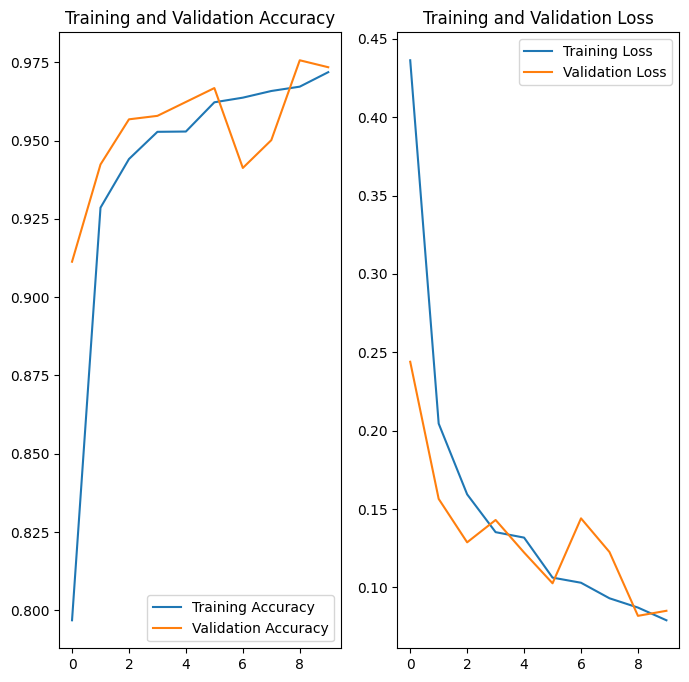

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = model.predict(test_generator)

141/141 [==============================] - 6s 44ms/step


[[2518   49]
 [  97 1845]]


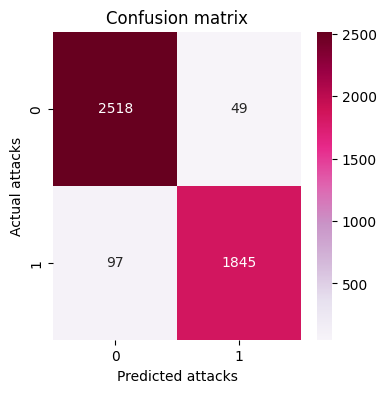

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2518   49]
 [  97 1845]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.96      0.98      0.97      2567
      normal       0.97      0.95      0.96      1942

    accuracy                           0.97      4509
   macro avg       0.97      0.97      0.97      4509
weighted avg       0.97      0.97      0.97      4509

